<a href="https://colab.research.google.com/github/odie2630463/pyro_tutorial/blob/master/Latent_Dirichlet_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyro-ppl

     |████████████████████████████████| 276kB 6.4MB/s 
     |████████████████████████████████| 748.9MB 19kB/s 
     |████████████████████████████████| 51kB 21.2MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-0.4.1-cp36-none-any.whl size=371731 sha256=621637853039cdd726d69e7582a6af92d029dc67b565dc25e9d0dbe0b7e4175c
  Stored in directory: /root/.cache/pip/wheels/fb/47/97/848e699fb40fc9fd17f421c135cf7bc121dcf3f0c8519e89b2
Successfully built pyro-ppl
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import random
import numpy as np
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro import sample , poutine , plate , param
from pyro.contrib.autoguide import AutoDiagonalNormal,AutoDelta,AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
pyro.enable_validation(True)

import matplotlib.pyplot as plt

## Synthetic data 

In [0]:
num_docs = 1000
len_docs = [random.randint(5,50) for _ in range(num_docs)]
num_topics = 5
num_words = 500

In [0]:
def generate_data():
  with plate("topics", num_topics):
    topic_words = sample("topic_words",
                         dist.Dirichlet(torch.zeros(num_words)+0.05))
  data = []
  topic_weights = []
  for i in plate("documents", num_docs):
    doc_topics = sample("doc_topics_{}".format(i), dist.Dirichlet(torch.zeros(num_topics)+0.1))
    topic_weights.append(doc_topics)
    
    with plate('words', len_docs[i]):
      word_topics = sample("word_topics", dist.Categorical(doc_topics))
      data_i = sample("doc_words", dist.Categorical(topic_words[word_topics]))
      data.append(data_i)
  
  return topic_words , topic_weights , data

In [0]:
topic_words , topic_weights , data  = generate_data()

In [0]:
data[0]

tensor([  5, 424, 366, 487,   5, 452,  90,  32,  44, 272,  90, 368,  32, 133,
        299, 461,  44])

In [0]:
@config_enumerate
def model(obs):
  with plate("topics", num_topics):
    topic_words = sample("topic_words",
                         dist.Dirichlet(torch.ones(num_words)*0.5))
    
  for i in plate("documents", num_docs):
    doc_topics = sample("doc_topics_{}".format(i), dist.Dirichlet(torch.ones(num_topics)*0.5))
    
    with plate('words_{}'.format(i), len_docs[i]):
      word_topics = sample("word_topics_{}".format(i), dist.Categorical(doc_topics))
      data = sample("doc_words_{}".format(i), dist.Categorical(topic_words[word_topics]) , obs=obs[i])

In [0]:
def guide(obs):
  topic_words_posterior = param("topic_words_posterior",
                                torch.ones(num_topics,num_words),
                                constraint=constraints.positive)
  with plate("topics", num_topics):
    sample("topic_words", dist.Dirichlet(topic_words_posterior))
  
  doc_topics_weights = param('doc_topics_weights', 
                             torch.ones(num_docs , num_topics), 
                             constraint=constraints.positive)
  
  for i in plate("documents", num_docs ,subsample_size=50):
    doc_topics = sample("doc_topics_{}".format(i), dist.Dirichlet(doc_topics_weights[i]))

In [0]:
pyro.clear_param_store()
elbo = TraceEnum_ELBO()
optim = pyro.optim.Adam({'lr': 1e-1})
svi = SVI(model, guide, optim, loss=elbo)

In [0]:
for _ in range(100):
  loss = svi.step(data)

print(loss)

160787.6875


In [0]:
w =dist.Dirichlet(pyro.get_param_store()["doc_topics_weights"]).sample()

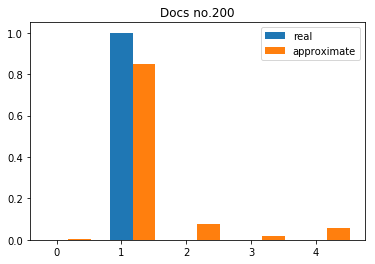

In [0]:
i = 200
bar_width = 0.35
plt.bar(np.arange(5) , topic_weights[i] ,bar_width , label='real')
plt.bar(np.arange(5)+bar_width , w[i] , bar_width , label='approximate')
plt.title('Docs no.{}'.format(i))
plt.legend()

In [0]:
v = dist.Dirichlet(pyro.get_param_store()["topic_words_posterior"]).sample()

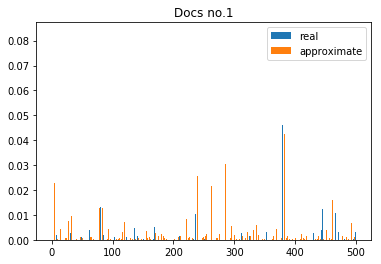

In [0]:
i = 1
bar_width = 0.5
plt.bar(np.arange(500) , topic_words[i] ,bar_width , label='real')
plt.bar(np.arange(500)+bar_width , v[i] , bar_width , label='approximate')
plt.title('Docs no.{}'.format(i))
plt.legend()